# Import Packages

In [1]:
import eofs
import os
from eofs.standard import Eof
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vtk
from vtk.util import numpy_support
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras.models import Sequential
from utils import funcs
from utils import lstm
import pyvista as pv
import glob

2023-07-05 17:11:15.093905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set hyperparameters/parameters

In [2]:
field_name = 'Velocity'  # set the field name to read in
filebase = 'fpc_'
input_data_path = 'data/cylinder/' # set the path to the data
output_data_path = 'data/pca_lstm_results/' # set the path to the data

## Get the field size of the data 

In [3]:
# Get the size of the data

reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(input_data_path + filebase + str(1) + '.vtu')
reader.Update()

# Get the unstructured grid data
ugrid = reader.GetOutput()

# Get the bounds of the unstructured grid data
x_min, x_max, y_min, y_max, z_min, z_max = ugrid.GetBounds()

# Compute the size of the field
x_size = x_max - x_min
y_size = y_max - y_min
z_size = z_max - z_min

print("Field size in x: ", x_size)
print("Field size in y: ", y_size)
print("Field size in z: ", z_size)


Field size in x:  2.2
Field size in y:  0.41
Field size in z:  0.0


## Set the resolution of the data

In [4]:
# set the resolution of the grid
x_res, y_res, z_res = int(x_size*100) , int(y_size*100), 1  

#set desired explained variance
targetVariance = 0.99

# set parameters to split the data
split_ratio = 0.2 # First 60% of data is used for training, the following 20% for validation and the remaining 20% for testing 
window_size = 30 # number of previous time steps to use as input variables to predict the next time period

# Set parameters for the LSTM model
batch_size = 100
no_epochs = 100
no_units = 128
patience = 5

# Transform Unstructured Data to Structured Data

In [6]:
# x_res, y_res, z_res = 220, 40, 1  # set the resolution of the grid
# field_name = 'Velocity'  # set the field name to read in
# filebase = 'fpc_'
all_data = []

# Loop over all file numbers
for file_num in range(1500):  # set the number of files to read in

    filename = input_data_path + filebase + str(file_num) + '.vtu'
    
    reader = vtk.vtkXMLUnstructuredGridReader()  # set the reader
    reader.SetFileName(filename)  # read the data
    reader.Update()

    # get the unstructured grid data
    ugrid = reader.GetOutput()

    # set the bounds of the unstructured grid data
    x_min, x_max, y_min, y_max, z_min, z_max = ugrid.GetBounds()
    
    # create a vtkImageData object
    imageData = vtk.vtkImageData()
    imageData.SetDimensions(x_res, y_res, z_res)
    imageData.SetOrigin(x_min, y_min, z_min)
    imageData.SetSpacing(
        (x_max - x_min) / x_res, (y_max - y_min) / y_res, (z_max - z_min) / z_res)

    # use the vtkProbeFilter to interpolate the data
    probe = vtk.vtkProbeFilter()
    probe.SetSourceData(ugrid)
    probe.SetInputData(imageData)
    probe.Update()

    # get the structured grid data after interpolation
    structuredGrid = probe.GetOutput()

    # Get the vtkDataArray object, which is the actual storage form of the structured grid data
    dataArray = structuredGrid.GetPointData().GetArray(field_name) 

    # Transform the vtkDataArray object to a NumPy array
    npArray = np.array(dataArray)
    npArray = npArray.flatten()

    # append the NumPy array to the list
    all_data.append(npArray)

# Transform the list to a NumPy array
all_data = np.array(all_data)

In [7]:
print(all_data.shape)
print(np.array(dataArray).shape)
data_shape = np.array(dataArray).shape

(1500, 27060)
(9020, 3)


# Perform PCA

## Attempt to find how many PCs we need to achieve the target variance

/var/folders/8s/5vt13vsx27v11srm2m8x03wm0000gp/T/ipykernel_18694/4139737946.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  solver = Eof(all_data)


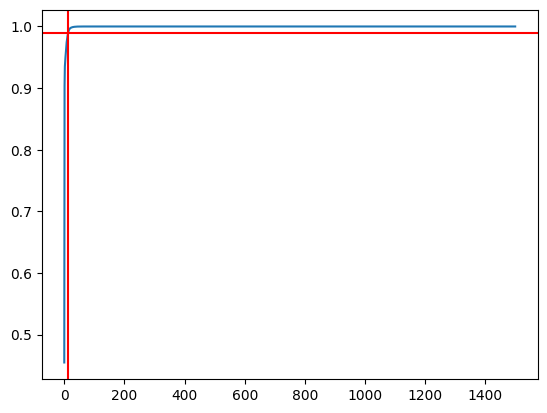

Number of PCs for 99.0% variance is: 14


In [8]:
#set desired explained variance
# targetVariance = 0.99

solver = Eof(all_data)

varianceCumulative = np.cumsum(solver.varianceFraction())
eigenvalues = solver.eigenvalues()
pcs = solver.pcs()
eof = solver.eofs()

minPCs = np.min(np.where(varianceCumulative>targetVariance))
plt.plot(varianceCumulative)
plt.axvline(minPCs, color='r')
plt.axhline(targetVariance, color='r')
plt.show()
print('Number of PCs for ' + str(targetVariance*100) + '% variance is: ' + str(minPCs))

## Use the PC number from the result above

In [9]:
# set the number of principal components
pca = PCA(n_components=minPCs)
pca_transformed = pca.fit_transform(all_data)
recovered = pca.inverse_transform(pca_transformed)
# recovered = recovered.reshape(np.array(all_data).shape)
mse_structured = mean_squared_error(all_data, recovered)
print(f'MSE: {mse_structured}')

MSE: 0.000291351498718726


In [10]:
print(pca_transformed.shape)
print(recovered.shape)

(1500, 14)
(1500, 27060)


# Perform LSTM

In [11]:
# # set parameters to split the data
# split_ratio = 0.2 # First 80% of data is used for training, remaining 20% for testing 
# window_size = 5 # number of previous time steps to use as input variables to predict the next time period

# normalize the data using MinMaxScaler in the range of [0, 1]
scaler = MinMaxScaler()
pca_normalized = scaler.fit_transform(pca_transformed)

# split the data into training and testing sets
data_len = pca_normalized.shape[0]
train_data = pca_normalized[:int(data_len*(1-split_ratio*2))]
val_data = pca_normalized[int(data_len*(1-split_ratio*2)):int(data_len*(1-split_ratio))]
test_data = pca_normalized[int(data_len*(1-split_ratio)):]

# split the data into input and output
x_train, y_train = funcs.create_dataset(train_data, window_size)
x_val, y_val = funcs.create_dataset(val_data, window_size)
x_test, y_test = funcs.create_dataset(test_data, window_size)

In [19]:
# an exmaple of how create_dataset works
a = np.array([1,2,3,4,5,6,7,8,9,10])
b,c = funcs.create_dataset(a, 5)
print(b,c)

[[1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]] [ 6  7  8  9 10]


In [13]:
print(train_data.shape, val_data.shape, test_data.shape)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(900, 14) (300, 14) (300, 14)
(870, 30, 14) (870, 14) (270, 30, 14) (270, 14) (270, 30, 14) (270, 14)


2023-07-05 17:12:45.066151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
9/9 [==============================] - 4s 138ms/step - loss: 0.1168 - mean_squared_error: 0.1168 - val_loss: 0.0523 - val_mean_squared_error: 0.0523
Epoch 2/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 3/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 4/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 5/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 6/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 7/100
9/9 [======================

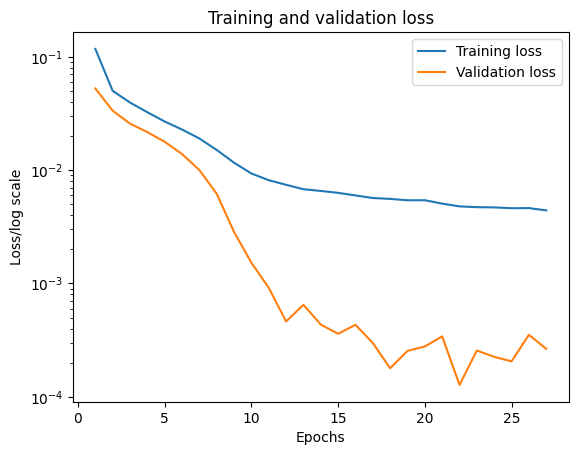

In [14]:
# # Set parameters
# batch_size = 100
# no_epochs = 100
# no_units = 128
# patience = 5

# Compile and train model
model = lstm.LSTMModel(train_data.shape[1], batch_size, no_epochs, no_units)
model.generate_and_compile_model(patience)
model.train(x_train, y_train, x_val, y_val)
# model.save()

# Plot losses
model.plot_loss()
# funcs.plot_loss(model.history)

In [15]:
# Predict on test set and save results
pred = model.predict(x_test)
mse = mean_squared_error(y_test, pred)
print(f'MSE: {mse}')
# np.save('predictions/lstm.npy', pred)

9/9 [==============================] - 1s 11ms/step
MSE: 0.00012886088713870888


In [16]:
pred_transformed = pca.inverse_transform(pred)
pred_reshaped = pred_transformed.reshape(pred_transformed.shape[0],data_shape[0],data_shape[1])
print(pred_reshaped.shape)

(270, 9020, 3)


# Save the predictions of test data to vtu files


In [17]:
# set the origin and spacing of the data
origin = (0, 0, 0) 
spacing = (x_size/x_res, y_size/y_res, z_size/z_res)  # spacing of the data

# if the output directory does not exist, create it
if not os.path.exists(output_data_path):
    os.makedirs(output_data_path)

for t in range(pred_reshaped.shape[0]):
    # get the data at time t
    data_t = pred_reshaped[t]

    # reshape the data to a 1D array
    data_t = data_t.reshape((x_res * y_res * z_res, 3))

    # transform the data to a vtkArray
    vtk_array = numpy_support.numpy_to_vtk(num_array=data_t, deep=True, array_type=vtk.VTK_FLOAT)

    # create a vtkImageData object
    image_data = vtk.vtkImageData()
    image_data.SetDimensions(x_res, y_res, z_res)
    image_data.SetDimensions(x_res, y_res, z_res)
    image_data.SetOrigin(origin)
    image_data.SetSpacing(spacing)
    image_data.GetPointData().SetVectors(vtk_array)

    # write the data to a .vti file
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(os.path.join(output_data_path, f'pca_lstm_results{t}.vti')) 
    writer.SetInputData(image_data)
    writer.Write()


# Use Weight and Biaes

In [18]:
# import wandb
# from wandb.keras import WandbCallback

# sweep_config = {
#     'method': 'random', #  grid or random
#     'metric': {
#       'name': 'val_loss',
#       'goal': 'minimize'   
#     },
#     'parameters': {
#         'no_units': {
#             'values': [64, 128, 256]
#         },
#         'batch_size': {
#             'values': [32, 64, 128]
#         },
#         'learning_rate': {
#             'min': 1e-5,
#             'max': 1e-2
#         },
#     }
# }
# def train():
#     config_defaults = {
#         'no_units': 128,
#         'batch_size': 100,
#         'learning_rate': 0.01,
#     }
#     wandb.init(config=config_defaults)
#     config = wandb.config
#     model = lstm.LSTMModel(train_data.shape[1], config.batch_size, no_epochs, config.no_units)
#     model.generate_and_compile_model(patience)
#     model.train(x_train, y_train, x_val, y_val)
#     model.save()

    
# sweep_id = wandb.sweep(sweep_config)
# wandb.agent(sweep_id, function=train)
